In [20]:
import numpy as np

import skimage.io
from scipy.ndimage import convolve
import matplotlib.pyplot as plt
import time
import math
import cv2
import copy


# New Section

Optimal within-class variance (σ=0): 673.7544426023596
Optimal within-class variance (σ=0.1): 673.7544426023596
Optimal within-class variance (σ=0.5): 335.0354559706856
Optimal within-class variance (σ=1): 142.99629745487437
Optimal within-class variance (σ=2.5): 126.60495568160576
Optimal within-class variance (σ=5): 160.61676184914847
Optimal within-class variance (σ=10): 217.76454514675277
Optimal within-class variance (σ=20): 253.34219041064514

The optimal sigma (σg) that minimizes the within-class variance is: 2.5


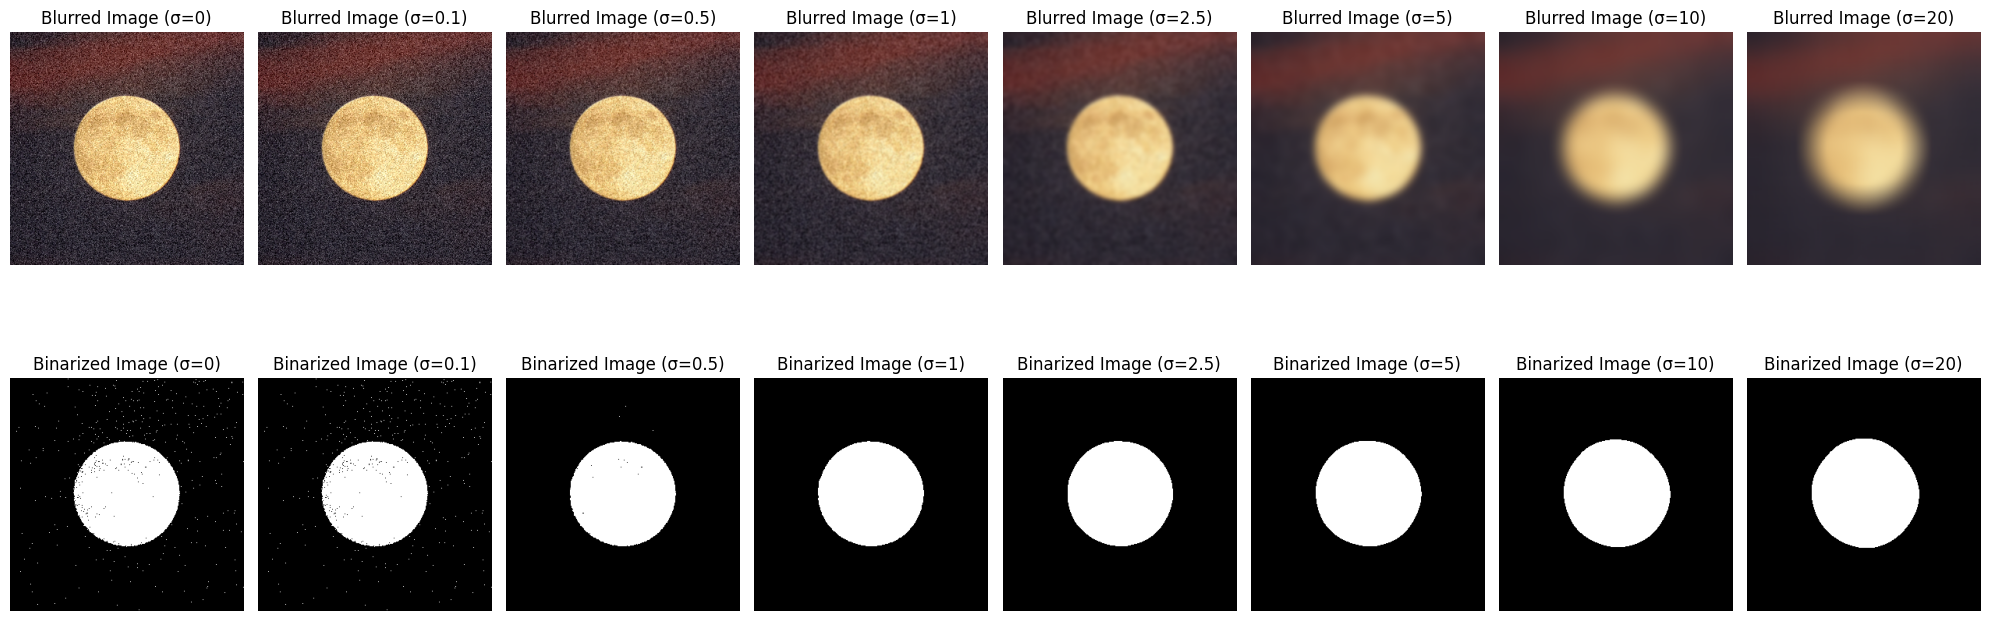

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
from scipy.ndimage import convolve
from skimage import color
import cv2

def histogram(image):

    hist, _ = np.histogram(image, bins=256, range=(0, 256))
    return hist

def within_class_variance(image, t):

    hist = histogram(image)
    p = hist / (image.shape[0] * image.shape[1])


    w0 = np.sum(p[:t+1])
    w1 = np.sum(p[t+1:])

    if w0 == 0 or w1 == 0:
        return float('inf')  # Avoid division by zero


    mu0 = np.sum(np.arange(t+1) * p[:t+1]) / w0
    mu1 = np.sum(np.arange(t+1, 256) * p[t+1:]) / w1


    sigma0_square = np.sum(((np.arange(t+1) - mu0) ** 2) * p[:t+1]) / w0
    sigma1_square = np.sum(((np.arange(t+1, 256) - mu1) ** 2) * p[t+1:]) / w1


    intra_class_variance = (sigma0_square * w0) + (sigma1_square * w1)

    return intra_class_variance

def find_optimal_threshold(image):

    variances = [within_class_variance(image, t) for t in range(256)]
    optimal_threshold = np.argmin(variances)
    return optimal_threshold, variances[optimal_threshold]

def binaryy(image, threshold_value):

    gray_image = color.rgb2gray(image)
    binary_image = gray_image > (threshold_value / 255.0)
    return binary_image

def gaussian_filter_matrix(sigma, size=41):

    gaussian_filter = np.zeros((size, size), dtype=np.float32)
    center = size // 2
    if sigma == 0:
        gaussian_filter[center, center] = 1
        return gaussian_filter
    for i in range(size):
        for j in range(size):
            x = i - center
            y = j - center
            gaussian_filter[i, j] = np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))
    gaussian_filter /= np.sum(gaussian_filter)
    return gaussian_filter


sigma_values = [0, 0.1, 0.5, 1, 2.5, 5, 10, 20]
img = skimage.io.imread('moon_noisy.png')

# Store the optimal within-class variances for each sigma
optimal_variances = []

fig, axes = plt.subplots(2, len(sigma_values), figsize=(20, 8))

for i, sigma in enumerate(sigma_values):
    img_copy = img.copy()

    # Separate channels for manual processing
    B = img[:, :, 0]  # Blue channel
    G = img[:, :, 1]  # Green channel
    R = img[:, :, 2]  # Red channel

    # Generate Gaussian filter for the given sigma
    gaussian_filter = gaussian_filter_matrix(sigma, size=41)

    # Apply the Gaussian filter to each channel
    B = convolve(B, gaussian_filter)
    G = convolve(G, gaussian_filter)
    R = convolve(R, gaussian_filter)

    # Stack the channels back
    img_blur = np.dstack((R, G, B))


    gray_image = color.rgb2gray(img_blur)
    gray_image = (gray_image * 255).astype(np.uint8)

    # Find optimal threshold and within-class variance
    optimal_threshold, optimal_variance = find_optimal_threshold(gray_image)
    optimal_variances.append(optimal_variance)

    # Apply the binary threshold using the optimal threshold
    binarized_img = binaryy(img_blur, optimal_threshold)

    # Plot the blurred image
    axes[0, i].imshow(cv2.cvtColor(img_blur.astype(np.uint8), cv2.COLOR_BGR2RGB))
    axes[0, i].set_title(f'Blurred Image (σ={sigma})')
    axes[0, i].axis('off')

    # Plot the binarized image
    axes[1, i].imshow(binarized_img, cmap='gray')
    axes[1, i].set_title(f'Binarized Image (σ={sigma})')
    axes[1, i].axis('off')

    # Print the optimal within-class variance for this sigma
    print(f'Optimal within-class variance (σ={sigma}): {optimal_variance}')

# Find the sigma that minimizes the within-class variance
optimal_sigma_index = np.argmin(optimal_variances)
optimal_sigma = sigma_values[optimal_sigma_index]
print(f"\nThe optimal sigma (σg) that minimizes the within-class variance is: {optimal_sigma}")

plt.tight_layout()
plt.show()


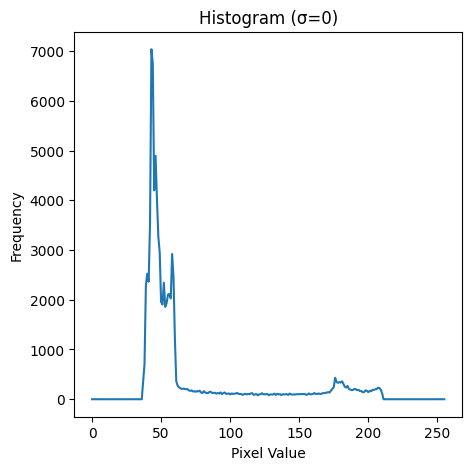

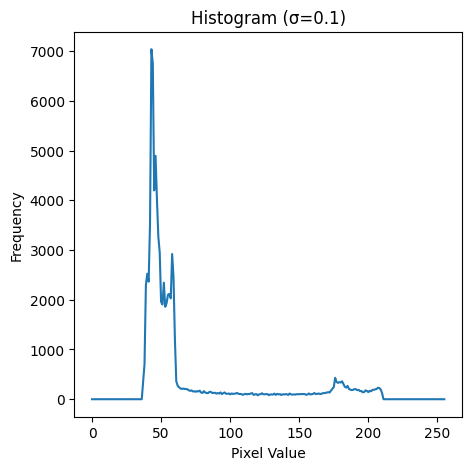

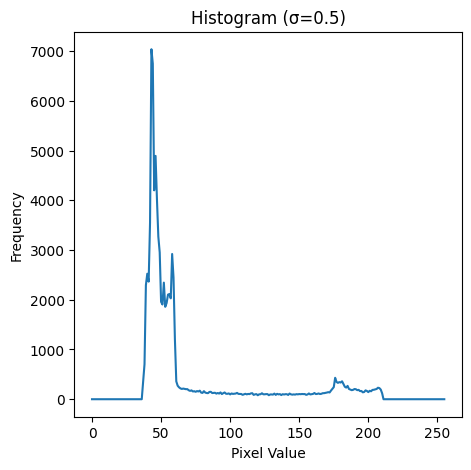

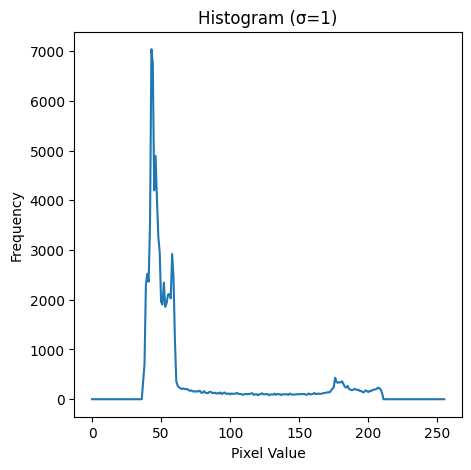

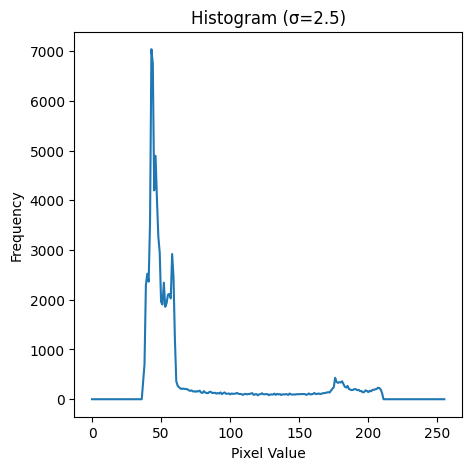

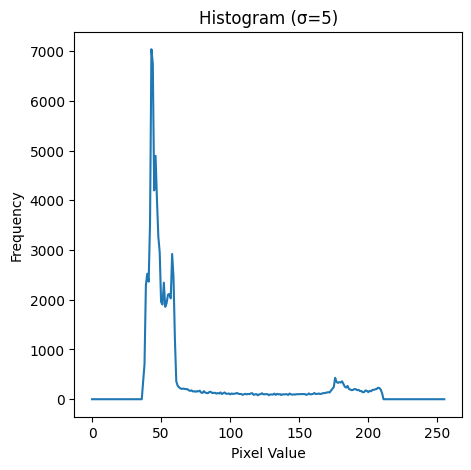

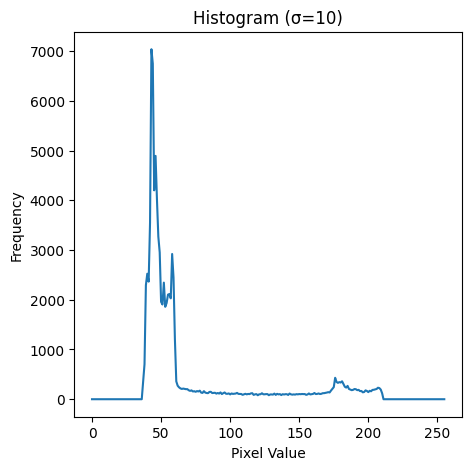

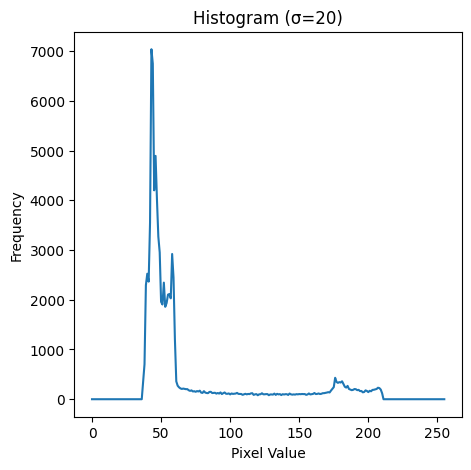

In [22]:
sigma_values = [0, 0.1, 0.5, 1, 2.5, 5, 10, 20]
for i in range(len(sigma_values)):

    c = histogram(gray_image)
    plt.figure(figsize = (5, 5)) # create a new figure for each histogram
    plt.plot(np.arange(256),c) # Use plt.plot to display the histogram
    plt.title(f'Histogram (σ={sigma_values[i]})')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()

# New Section

Downsampled Image Sample Values: [[179 177 175 174 176]
 [177 175 172 172 173]
 [176 172 170 169 172]
 [173 170 167 166 170]
 [171 169 166 164 166]]
Upsampled Image Sample Values: [[173 173 173 173 173]
 [173 172 172 172 172]
 [172 172 171 171 171]
 [171 171 171 171 171]
 [170 170 170 170 170]]
Upsampled Image Sample Values: [[174 173 173 172 172]
 [173 173 172 172 172]
 [172 172 171 171 171]
 [172 171 171 171 171]
 [170 170 170 170 170]]


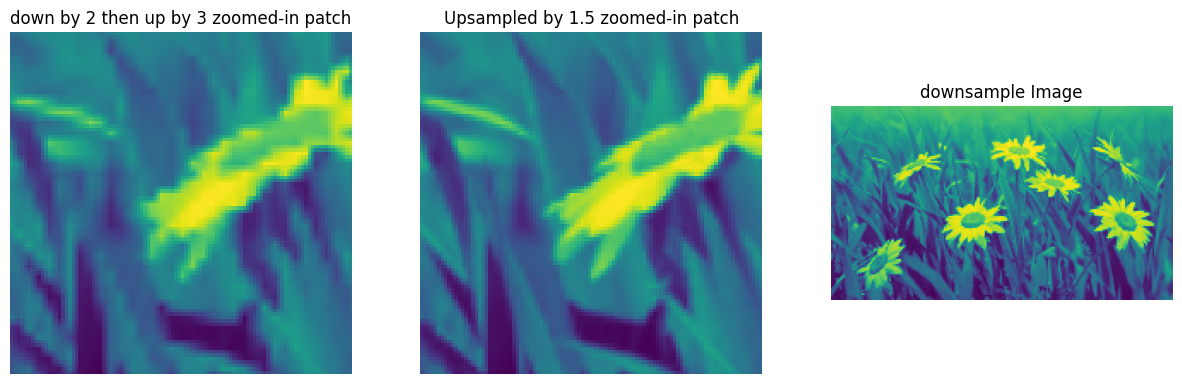

In [23]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
img2 = Image.open("flowers.png")
img2 = np.array(img2)
img2_1=img2.copy()

def downsample(image, factor):

    if factor <= 1:
        raise ValueError("Downsampling factor must be greater than 1.")

    old_height, old_width = image.shape
    new_height = int(old_height // factor)
    new_width = int(old_width // factor)


    downsampled_img = np.zeros((new_height, new_width), dtype=np.float32)

    for i in range(new_height):
        for j in range(new_width):
            x = j * factor
            y = i * factor
            downsampled_img[i, j] = bilinear_interpolate(image, x, y)


    downsampled_img = np.clip(downsampled_img, 0, 255).astype(np.uint8)

    print("Downsampled Image Sample Values:", downsampled_img[0:5, 0:5])  # Display a sample of the downsampled image

    return downsampled_img

def bilinear_interpolate(img, x, y):

    height, width = img.shape
    x1, y1 = int(x), int(y)
    x2, y2 = min(x1 + 1, width - 1), min(y1 + 1, height - 1)

    Q11 = img[y1, x1]
    Q12 = img[y2, x1]
    Q21 = img[y1, x2]
    Q22 = img[y2, x2]

    # If x1 equals x2 or y1 equals y2, avoid interpolation (degenerate cases)
    if x1 == x2 and y1 == y2:
        return Q11
    elif x1 == x2:
        P = (y2 - y) * Q11 + (y - y1) * Q12
        return P
    elif y1 == y2:
        P = (x2 - x) * Q11 + (x - x1) * Q21
        return P

    # Perform bilinear interpolation calculation
    R1 = (x2 - x) * Q11 + (x - x1) * Q21
    R2 = (x2 - x) * Q12 + (x - x1) * Q22

    P = (y2 - y) * R1 + (y - y1) * R2
    return P

def upsample(image, factor):

    if factor <= 1:
        raise ValueError("Upsampling factor must be greater than 1.")

    old_height, old_width = image.shape
    new_height = int(old_height * factor)
    new_width = int(old_width * factor)


    upsampled_img = np.zeros((new_height, new_width), dtype=np.float32)

    for i in range(new_height):
        for j in range(new_width):

            x = j / factor
            y = i / factor

            # Check if x and y are within valid range
            if x >= old_width or y >= old_height:
                continue

            interpolated_value = bilinear_interpolate(image, x, y)

            upsampled_img[i, j] = interpolated_value

    # Convert back to np.uint8 after interpolation
    upsampled_img = np.clip(upsampled_img, 0, 255).astype(np.uint8)

    print("Upsampled Image Sample Values:", upsampled_img[0:5, -5:])  # Display a sample of the rightmost columns

    return upsampled_img


# Downsample the image by a factor of 2
downsampled_image = downsample(img2_1, 2)

# Upsample the downsampled image by a factor of 3
upsampled_image = upsample(downsampled_image, 3)

# Upsample the image by a factor of 1.5
upsampled_ima = upsample(img2_1, 1.5)

# Create a zoomed-in patch for the upsampled image
x_start, y_start, patch_width, patch_height = 70, 70, 100, 100

# Create a zoomed-in patch for the downsampled image by factor 2
zoomed_patch_downsample = downsampled_image[y_start:y_start + patch_height, x_start:x_start + patch_width]

# Create a zoomed-in patch for the upsampled image by factor of 3
zoomed_patch_upsampled = upsampled_image[y_start:y_start + patch_height, x_start:x_start + patch_width]

# create a zoomed-in patch for upsampled image by factor of 1.5
zoomed_patch_upsam = upsampled_ima[y_start:y_start + patch_height, x_start:x_start + patch_width]

#create a zoomed-in patch for
plt.figure(figsize=(15, 10))


# Part (a) result: Downsampled and then Upsampled
plt.subplot(1, 3, 1)
plt.imshow(zoomed_patch_upsampled)
plt.title('down by 2 then up by 3 zoomed-in patch')
plt.axis('off')

# Part (b) result: Upsampled by 1.5
plt.subplot(1, 3, 2)
plt.imshow(zoomed_patch_upsam)
plt.title('Upsampled by 1.5 zoomed-in patch')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(downsampled_image)
plt.title('downsample Image')
plt.axis('off')



plt.show()


In [24]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Function to adjust brightness
def brightnessAdjust(img, p):
    # Clamp p value between 0 and 1
    p = np.clip(p, 0, 1)

    # Calculate the brightness adjusted image
    adjusted = cv2.addWeighted(img, 1.0, np.zeros(img.shape, img.dtype), 0, (512 * (p - 0.5)))
    return adjusted

# Function to adjust contrast
def contrastAdjust(img, p):
    # Clamp p value between 0 and 1
    p = np.clip(p, 0, 1)

    if p == 0:
        # Output a grey image
        adjusted = np.full(img.shape, 128, dtype=img.dtype)
    elif p == 1:
        # Output a binarized image
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, adjusted = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
        adjusted = cv2.cvtColor(adjusted, cv2.COLOR_GRAY2BGR)
    else:
        # Adjust contrast gradually based on p
        adjusted = cv2.addWeighted(img, 1 + (p - 0.5) * 2, np.zeros(img.shape, img.dtype), 0, 128 * (0.5 - p))

    return adjusted

In [25]:
# Load the uploaded image
image_path = 'brightness_contrast.jpg'
img = cv2.imread(image_path)

# Convert the image from BGR to RGB for proper display
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

(-0.5, 1919.5, 1279.5, -0.5)

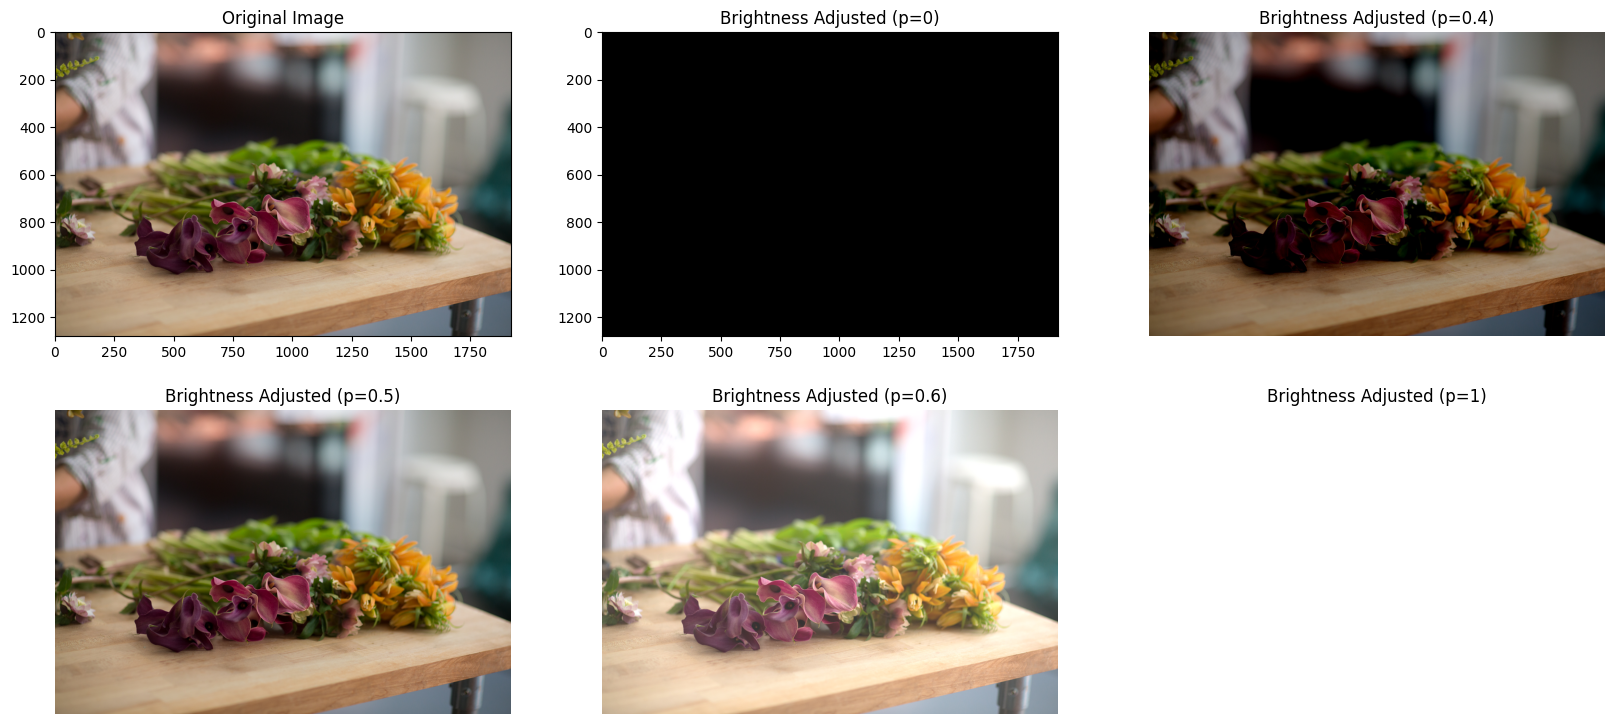

In [26]:


# Testing the functions
brightness_img_p0 = brightnessAdjust(img_rgb, 0)  # Decrease brightness
brightness_img_p40 = brightnessAdjust(img_rgb, 0.4)  # Decrease brightness
brightness_img_p50 = brightnessAdjust(img_rgb, 0.5)  # Same brightness
brightness_img_p60 = brightnessAdjust(img_rgb, 0.6)  # Increase brightness
brightness_img_p100 = brightnessAdjust(img_rgb, 1)  # Increase brightness


# Display the original and adjusted images
plt.figure(figsize=(20, 9))

plt.subplot(2, 3, 1)
plt.title("Original Image")
plt.imshow(img_rgb)

plt.subplot(2, 3, 2)
plt.title("Brightness Adjusted (p=0)")
plt.imshow(brightness_img_p0)

plt.subplot(2, 3, 3)
plt.title("Brightness Adjusted (p=0.4)")
plt.imshow(brightness_img_p40)
plt.axis('off')

plt.subplot(2, 3, 4)
plt.title("Brightness Adjusted (p=0.5)")
plt.imshow(brightness_img_p50)
plt.axis('off')

plt.subplot(2, 3, 5)
plt.title("Brightness Adjusted (p=0.6)")
plt.imshow(brightness_img_p60)
plt.axis('off')

plt.subplot(2, 3, 6)
plt.title("Brightness Adjusted (p=1)")
plt.imshow(brightness_img_p100)
plt.axis('off')


(-0.5, 1919.5, 1279.5, -0.5)

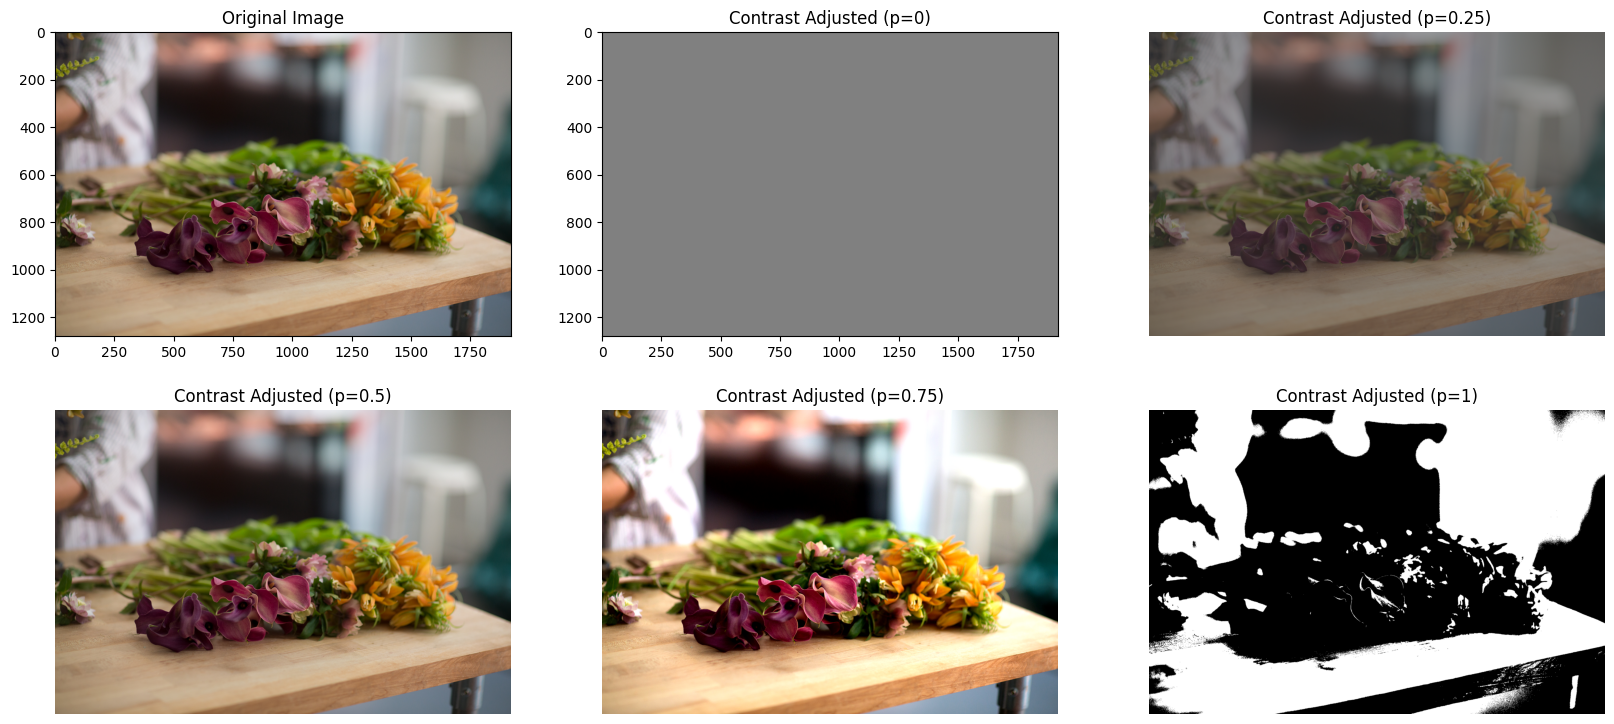

In [27]:
contrast_img_p0 = contrastAdjust(img_rgb, 0)      # Decrease contrast
contrast_img_p25 = contrastAdjust(img_rgb, 0.25)      # Decrease contrast
contrast_img_p50 = contrastAdjust(img_rgb, 0.5)      # Decrease contrast
contrast_img_p75 = contrastAdjust(img_rgb, 0.75)      # Decrease contrast
contrast_img_p100 = contrastAdjust(img_rgb, 1)      # Decrease contrast


# Display the original and adjusted images
plt.figure(figsize=(20, 9))

plt.subplot(2, 3, 1)
plt.title("Original Image")
plt.imshow(img_rgb)

plt.subplot(2, 3, 2)
plt.title("Contrast Adjusted (p=0)")
plt.imshow(contrast_img_p0)

plt.subplot(2, 3, 3)
plt.title("Contrast Adjusted (p=0.25)")
plt.imshow(contrast_img_p25)
plt.axis('off')

plt.subplot(2, 3, 4)
plt.title("Contrast Adjusted (p=0.5)")
plt.imshow(contrast_img_p50)
plt.axis('off')

plt.subplot(2, 3, 5)
plt.title("Contrast Adjusted (p=0.75)")
plt.imshow(contrast_img_p75)
plt.axis('off')

plt.subplot(2, 3, 6)
plt.title("Contrast Adjusted (p=1)")
plt.imshow(contrast_img_p100)
plt.axis('off')
